## Comaprison of different Variational Methods 

In this notebook, we evaluate the performance of different methods. It compares the methods descripbed in 

* https://arxiv.org/pdf/1502.05336.pdf (Probabilistic Backpropagation for Scalable
Learning of Bayesian Neural Networks)
* https://arxiv.org/abs/1506.02142 (Gal)

* No Just Backprob:         3.228 +- 0.1951 (Lobato and Gal report the same error)
* MC-Droput:                2.97 ±0.85 (Gal)
* Probabalistic Backprob:   3.01 ±0.18 (Lobato and Gal)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev20190426
TF  Version 2.0.0-alpha0


Loading the Boston data

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
X = boston.data
y = boston.target
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(X))
X = scaler.transform(X)
X = np.asarray(X, np.float32)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X = X_train
y = y_train
X.shape, y.shape, y_train.shape, y_test.shape, X.min(), X.max()

StandardScaler(copy=True, with_mean=True, with_std=True)


((455, 13), (455,), (455,), (51,), -3.9071934, 9.93393)

### Global Settings

In [14]:
sgd = tf.keras.optimizers.SGD(lr=.01, momentum=0.9, nesterov=True)
epochs = 500
bs = 32
loops = 3

In [17]:
# 
from sklearn.model_selection import train_test_split
def check_performance(build_model, X, y, mc_loops=-1):
    accs = np.zeros((loops))
    hists = list()
    for r in range(loops):  
        model = build_model()  
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        X = X_train
        y = y_train
        hist = model.fit(X_train, y_train, epochs=epochs, verbose=False)
        hists.append(hist)
        if mc_loops < 1:
            accs[r] = np.sqrt(np.mean((model.predict(X_test)[:,0] - y_test)**2))
        else:
            y_pres = np.zeros((len(y_test), mc_loops))
            for m in range(mc_loops):
                y_pres[:,m] = model.predict(X_test)[:,0]
            y_m = np.mean(y_pres,axis=1)
            accs[r] = np.sqrt(np.mean((y_m - y_test)**2))
    return accs, hists

def makeStats(accs):
    return np.mean(accs), np.std(accs)/np.sqrt(len(accs))




Using ReLU

In [34]:
#Lobato We use neural networks with 50 hidden units in all cases except in the two largest ones
def build_model(): 
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(50, activation = 'relu', input_shape=(X.shape[1],)))
    model.add(tf.keras.layers.Dense(1,))
    sgd = tf.keras.optimizers.SGD(lr=.005, momentum=0.9, nesterov=True)
    model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
    return model
accs_noreg_relu, hists_noreg_relu = check_performance(build_model, X,y)

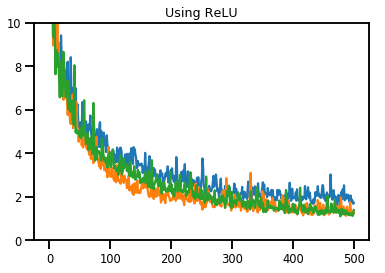

(3.068005169241116, 0.27094373861956067)


In [35]:
for i in range(loops):
    plt.plot(hists_noreg_relu[i].history['loss'])
plt.ylim(0,10)
plt.title('Using ReLU')
plt.show()
print(makeStats(accs_noreg_relu))

Using tanh

In [37]:
#Lobato We use neural networks with 50 hidden units in all cases except in the two largest ones
def build_model(): 
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(50, activation = 'tanh', input_shape=(X.shape[1],)))
    model.add(tf.keras.layers.Dense(1,))
    model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
    return model
accs_noreg_tanh, hists_noreg_tanh = check_performance(build_model, X,y)

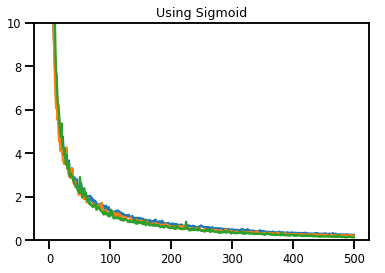

(3.870404738085933, 0.33239202829381526)


In [38]:
for i in range(loops):
    plt.plot(hists_noreg_tanh[i].history['loss'])
plt.ylim(0,10)
plt.title('Using Tanh')
plt.show()
print(makeStats(accs_noreg_tanh))


Using sigmoid

In [39]:
#Lobato We use neural networks with 50 hidden units in all cases except in the two largest ones
def build_model(): 
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(50, activation = 'sigmoid', input_shape=(X.shape[1],)))
    model.add(tf.keras.layers.Dense(1,))
    model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
    return model
accs_noreg, hists_noreg = check_performance(build_model, X,y)

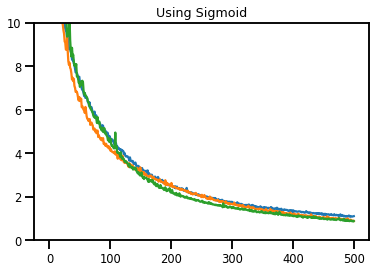

(3.319203116032249, 0.2897117824508297)


In [40]:
for i in range(loops):
    plt.plot(hists_noreg[i].history['loss'])
plt.ylim(0,10)
plt.title('Using Sigmoid')
plt.show()
print(makeStats(accs_noreg))


In [52]:
def build_model(): 
    kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)
    model = tf.keras.Sequential()
    model.add(tfp.layers.DenseReparameterization(50, activation = 'sigmoid', kernel_divergence_fn=kernel_divergence_fn,input_shape=(X.shape[1],)))
    model.add(tfp.layers.DenseReparameterization(1,kernel_divergence_fn=kernel_divergence_fn))
    model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
    return model

accs_denserep_10, hists__denserep_10 = check_performance(build_model, X,y, mc_loops=10)

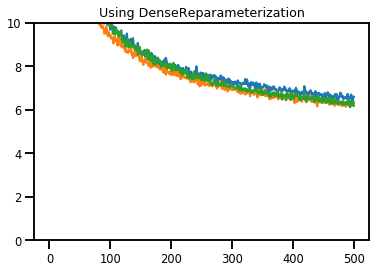

(3.319203116032249, 0.2897117824508297)
(3.2459703637520474, 0.2837070068032831)


In [53]:
for i in range(loops):
    plt.plot(hists__denserep_10[i].history['loss'])
plt.ylim(0,10)
plt.title('Using DenseReparameterization')
plt.show()
print(makeStats(accs_noreg))
print(makeStats(accs_denserep_10))


In [66]:
def build_model(): 
    kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)
    model = tf.keras.Sequential()
    model.add(tfp.layers.DenseFlipout(50, activation = 'sigmoid', kernel_divergence_fn=kernel_divergence_fn,input_shape=(X.shape[1],)))
    model.add(tfp.layers.DenseFlipout(1,kernel_divergence_fn=kernel_divergence_fn))
    model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
    return model

accs_denseflip_10, hists_denseflip_10 = check_performance(build_model, X,y, mc_loops=10)

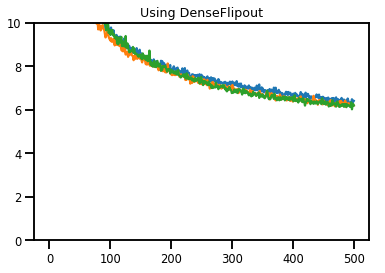

(3.2459703637520474, 0.2837070068032831)
(3.0846825944901393, 0.22747432094127762)


In [71]:
for i in range(loops):
    plt.plot(hists_denseflip_10[i].history['loss'])
plt.ylim(0,10)
plt.title('Using DenseFlipout')
plt.show()


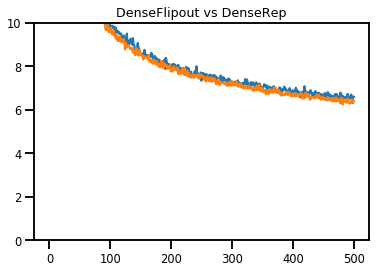

In [84]:
plt.plot(hists__denserep_10[0].history['loss'])
plt.plot(hists_denseflip_10[0].history['loss'])
plt.ylim(0,10)
plt.title('DenseFlipout vs DenseRep')
plt.show()


In [77]:
def build_model(): 
    def MCDropout(rate):
        return tf.keras.layers.Lambda(lambda x: tf.keras.backend.dropout(x, level=rate))
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(50, activation = 'sigmoid',input_shape=(X.shape[1],)))
    model.add(MCDropout(0.05))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
    return model

accs_dense_mc, hists_dense_mc = check_performance(build_model, X,y, mc_loops=10)

W0502 22:53:48.290809 4397077952 deprecation.py:506] From /Users/oli/.virtualenvs/tensorflow_prob/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


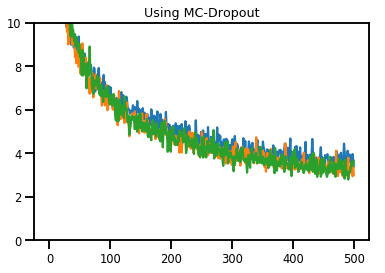

(3.0288846987845184, 0.1984977384770226)


In [80]:
for i in range(loops):
    plt.plot(hists_dense_mc[i].history['loss'])
plt.ylim(0,10)
plt.title('Using MC-Dropout')
plt.show()
print(makeStats(accs_dense_mc))


In [83]:
print("Dense Rep", makeStats(accs_denserep_10))
print("Dense Flipout", makeStats(accs_denseflip_10))
print("MC-Dropout", makeStats(accs_dense_mc))
print("Baseline", makeStats(accs_noreg))



Dense Rep (3.2459703637520474, 0.2837070068032831)
Dense Flipout (3.0846825944901393, 0.22747432094127762)
MC-Dropout (3.0288846987845184, 0.1984977384770226)
Baseline (3.319203116032249, 0.2897117824508297)
